# test 初始全凍結

In [1]:
# import os
# import kaggle
# from kaggle.api.kaggle_api_extended import KaggleApi

# # 設定下載路徑
# download_path = '/mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/Stanford Background Dataset'
# os.makedirs(download_path, exist_ok=True)

# # 初始化 Kaggle API
# api = KaggleApi()
# api.authenticate()

# # 下載資料集
# print("開始下載 Stanford Background Dataset...")
# api.dataset_download_files('balraj98/stanford-background-dataset', 
#                          path=download_path,
#                          unzip=True)

# print("資料集下載完成，保存在:", download_path)

In [2]:
# !kaggle competitions download -c nycu-iaii-ml-2025-classification
# !unzip -q nycu-iaii-ml-2025-classification.zip

In [3]:
# !pip install torch torchvision tqdm pillow numpy pandas
# 檢查 CUDA 是否可用
# import torch
# print(f"PyTorch 版本: {torch.__version__}")
# print(f"CUDA 是否可用: {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"GPU 型號: {torch.cuda.get_device_name(0)}")
#     print(f"可用 GPU 數量: {torch.cuda.device_count()}")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
import torchvision.transforms.v2 as T
from PIL import Image
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import random
import glob
import math

# --- 輔助函數 ---
def _can_load_optimizer(curr_optim, saved_state):
    try:
        saved_groups = saved_state["param_groups"]
    except Exception:
        return False
    curr_groups = curr_optim.param_groups
    if len(curr_groups) != len(saved_groups):
        return False
    for g_cur, g_sv in zip(curr_groups, saved_groups):
        if len(g_cur.get("params", [])) != len(g_sv.get("params", [])):
            return False
    return True

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# === Dataset 與增強 (從原 In[6] 繼承) ===
class SimpsonsDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train', classes=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

        if mode == 'train':
            self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
            self.images, self.labels = [], []
            for cls in self.classes:
                cdir = os.path.join(root_dir, cls)
                for f in os.listdir(cdir):
                    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(cdir, f))
                        self.labels.append(self.class_to_idx[cls])
        else:
            self.classes = classes
            def _numkey(fn):
                digits = ''.join(ch for ch in fn if ch.isdigit())
                return int(digits) if digits else 0
            files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            files.sort(key=_numkey)
            self.images = [os.path.join(root_dir, f) for f in files]
            self.labels = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.mode == 'train':
            return image, self.labels[idx]
        else:
            return image, os.path.basename(img_path)

class BackgroundMixing(object):
    def __init__(self, background_dir, p=0.2, alpha_range=(0.85, 1.0)):
        self.background_dir = background_dir
        self.p = p
        self.alpha_range = alpha_range
        self.background_images = glob.glob(os.path.join(background_dir, '*.jpg')) + \
                                 glob.glob(os.path.join(background_dir, '*.png'))
        if not self.background_images:
            print(f"Warning: No background images found in {background_dir}. BackgroundMixing will be skipped.")
            self.p = -1
            self.background_images = ['dummy']

    def __call__(self, img):
        if random.random() > self.p or self.p == -1:
            return img
        bg = Image.open(random.choice(self.background_images)).convert('RGB')
        bg = bg.resize(img.size, Image.Resampling.BILINEAR)
        alpha = random.uniform(*self.alpha_range)
        return Image.blend(bg, img, alpha)

# Stanford Background Dataset 路徑（依你的環境）
background_dir = "/mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/Stanford Background Dataset/images"

# 訓練與驗證前處理（人臉友善、避免過度裁小）

# 弱處理
train_weak_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 強處理
background_dir = "/mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/Stanford Background Dataset/images"
train_strong_transform = T.Compose([
    BackgroundMixing(background_dir, p=0.35, alpha_range=(0.3, 0.7)),
    T.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.75, 1.33)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.RandomRotation(10)], p=0.2),
    T.RandomApply([T.RandomPerspective(distortion_scale=0.4, p=1.0)], p=0.2),
    T.RandomApply([T.ElasticTransform(alpha=80.0)], p=0.15),
    T.RandomApply([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.08)], p=0.4),
    T.RandomGrayscale(p=0.1),
    T.RandomInvert(p=0.05),
    T.RandomPosterize(bits=4, p=0.1),
    T.RandomApply([T.RandomSolarize(threshold=192)], p=0.05),
    T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0))], p=0.2),
    T.ToTensor(),
    T.RandomApply([T.Lambda(lambda x: x + 0.05*torch.randn_like(x))], p=0.3),
    T.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3), value='random'),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 驗證/測試處理
test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MixUp:
    def __init__(self, alpha=0.4, num_classes=50): # alpha=0.4
        self.alpha = alpha
        self.num_classes = num_classes
    def __call__(self, batch):
        inputs, labels = batch
        b = inputs.size(0)
        lam = torch.distributions.Beta(self.alpha, self.alpha).sample(torch.Size([b])).to(inputs.device)
        lam = torch.max(lam, 1 - lam).view(-1,1,1,1)
        idx = torch.randperm(b, device=inputs.device)
        mixed = lam * inputs + (1 - lam) * inputs[idx]
        onehot = torch.zeros(b, self.num_classes, device=inputs.device)
        onehot.scatter_(1, labels.view(-1,1), 1)
        soft = lam.view(-1,1) * onehot + (1 - lam.view(-1,1)) * onehot[idx]
        return mixed, soft

class CutMix:
    def __init__(self, alpha=1.0, num_classes=50):
        self.alpha = alpha
        self.num_classes = num_classes
    def __call__(self, batch):
        inputs, labels = batch
        b, _, H, W = inputs.size()
        lam = torch.distributions.Beta(self.alpha, self.alpha).sample().item()
        cx, cy = np.random.randint(W), np.random.randint(H)
        w = int(W * np.sqrt(1 - lam))
        h = int(H * np.sqrt(1 - lam))
        x1 = np.clip(cx - w // 2, 0, W)
        y1 = np.clip(cy - h // 2, 0, H)
        x2 = np.clip(cx + w // 2, 0, W)
        y2 = np.clip(cy + h // 2, 0, H)
        idx = torch.randperm(b, device=inputs.device)
        mixed = inputs.clone()
        mixed[:, :, y1:y2, x1:x2] = inputs[idx, :, y1:y2, x1:x2]
        lam_actual = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        onehot = torch.zeros(b, self.num_classes, device=inputs.device)
        onehot.scatter_(1, labels.view(-1,1), 1)
        soft = lam_actual * onehot + (1 - lam_actual) * onehot[idx]
        return mixed, soft
    
# 讓一張圖有兩條處理路徑：原圖弱增強(3) 與 強增強(7)
class DualTransform:
    def __init__(self, orig_tf, aug_tf, p_aug=0.7):
        self.orig_tf = orig_tf
        self.aug_tf = aug_tf
        self.p_aug = p_aug

    def __call__(self, img):
        if random.random() < self.p_aug:
            return self.aug_tf(img)
        else:
            return self.orig_tf(img)

# 設置可訓練參數
def set_trainable(model_layer, requires_grad=True):
    for param in model_layer.parameters():
        param.requires_grad = requires_grad
        
import torch.optim as optim

# NEW: reconfigure_optimizer 函數
def reconfigure_optimizer(old_optimizer, model, new_lr, new_weight_decay, original_lr):
    
    param_groups = []
    
    fc_params = [param for name, param in model.named_parameters() if 'fc' in name and param.requires_grad]
    if fc_params:
        param_groups.append({
            'params': fc_params, 
            'lr': original_lr,
            'weight_decay': new_weight_decay
        })

    base_params = [param for name, param in model.named_parameters() 
                   if 'fc' not in name and param.requires_grad]
    if base_params:
        param_groups.append({
            'params': base_params, 
            'lr': new_lr,
            'weight_decay': new_weight_decay
        })
        
    param_groups = [p for p in param_groups if p['params']]
    
    optimizer = optim.AdamW(param_groups, lr=new_lr, weight_decay=new_weight_decay)

    print(f"優化器重新配置：總參數群組數: {len(optimizer.param_groups)}")
    for i, group in enumerate(optimizer.param_groups):
        print(f"  Group {i}: LR={group['lr']:.6f}, WD={group['weight_decay']:.6f}, Params={len(group['params'])}")
        
    return optimizer

/home/yuxin/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:

# 載入預訓練的 ResNet101 模型並修改最後的全連接層
def get_model(num_classes=50):
    model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
    for name, param in model.named_parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 2048),
        nn.GroupNorm(32, 2048),
        nn.GELU(),
        nn.Dropout(0.4),
        nn.Linear(2048, 1024),
        nn.GroupNorm(32, 1024),
        nn.GELU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.GroupNorm(16, 512),
        nn.GELU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_classes)
    )
    return model

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.criterion = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = F.log_softmax(pred, dim=1)
        with torch.no_grad():
            # 確保 target 是 long 類型
            target = target.long()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return self.criterion(pred, true_dist)

# --- EMA/Loss/Model/Train Functions ---
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        # NEW: 初始化時獲取模型的設備
        self.device = next(model.parameters()).device
        self.shadow = {}
        self.register(model, include_non_trainable=False)

    def register(self, model, include_non_trainable=False):
        # NEW: 確保註冊時，shadow 權重被複製到正確的設備
        self.shadow = {
            # 確保 detach 後立即移到正確的設備
            name: p.detach().clone().to(self.device) 
            for name, p in model.named_parameters()
            if include_non_trainable or p.requires_grad
        }

    def update(self, model):
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            
            if (name not in self.shadow) or (self.shadow[name].shape != p.data.shape):
                # 如果是新解凍的權重，重新註冊並將其移到正確設備
                self.shadow[name] = p.detach().clone().to(self.device)
                continue
            
            # **⭐⭐ FIXED: 確保模型權重在更新前移到 shadow 權重的設備上進行計算 ⭐⭐**
            # 這裡 p.data 是 cuda:0，self.shadow[name] 也在 cuda:0。
            # 但為了魯棒性，我們明確要求 p.data 必須使用 shadow 的設備 (self.device)
            p_data_on_device = p.data.to(self.device)
            
            # 核心 EMA 更新公式
            new_avg = (1.0 - self.decay) * p_data_on_device + self.decay * self.shadow[name]
            self.shadow[name].copy_(new_avg) 

    def state_dict(self):
        # NEW: 保存時將 shadow 移回 CPU
        return {"decay": self.decay, "shadow": {k: v.cpu() for k, v in self.shadow.items()}, "device": str(self.device)}

    def load_state_dict(self, state):
        self.decay = state.get("decay", self.decay)
        # 恢復設備信息，但只使用 'cuda:0' 或 'cpu'
        self.device = torch.device(state.get("device", "cpu").split(':')[0]) 
        # NEW: 加載時確保 shadow 權重被移到正確設備
        self.shadow = {k: v.to(self.device) for k, v in state["shadow"].items()}

    def apply_shadow(self, model):
        self.backup = {}
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            self.backup[name] = param.data.clone()
            param.data.copy_(self.shadow[name].to(param.data.device)) # 確保還原時，shadow 在模型權重所在設備

    def restore(self, model):
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            param.data.copy_(self.backup[name])
        self.backup = {}


# 訓練函數 (FIXED: 使用返回值更新 optimizer/scheduler)
# 訓練函數 (FIXED: 使用返回值更新 optimizer/scheduler)
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=10, device='cuda', mixup=None, cutmix=None, aug_version=None):
    best_acc = 0.0
    best_model_state = None
    # 確保關鍵全局變數可用
    global start_epoch, history, LEARNING_RATE, WEIGHT_DECAY, ckpt

    ema = EMA(model, decay=0.999)

    if start_epoch > 0:
        best_acc = max(history.get('val_acc', [0.0]))
        if 'ema_state' in ckpt:
            try:
                ema.load_state_dict(ckpt['ema_state'])
            except Exception as e:
                print(f"EMA 狀態恢復失敗: {e}. 將使用新初始化.")

    for epoch in range(start_epoch, num_epochs):
        
        # --- Gradual Unfreezing and LR Schedule (FIXED & EXTENDED) ---
        
        # Epoch 4 (index 3): Unfreeze layer4, LR * 0.2
        if epoch == 3:
            print("解凍 layer4 並重建優化器（LR * 0.2）...")
            set_trainable(model.layer4, True)
            optimizer = reconfigure_optimizer(optimizer, model, LEARNING_RATE * 0.2, WEIGHT_DECAY, LEARNING_RATE)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
            ema.register(model)

        # Epoch 16 (index 15): Unfreeze layer3, LR * 0.1
        if epoch == 15:
            print("解凍 layer3 並重建優化器（LR * 0.1）...")
            set_trainable(model.layer3, True)
            optimizer = reconfigure_optimizer(optimizer, model, LEARNING_RATE * 0.1, WEIGHT_DECAY, LEARNING_RATE)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
            ema.register(model)
            
        # Epoch 30 (index 29): Unfreeze layer2, LR * 0.025
        if epoch == 29:
             print("解凍 layer2 並重建優化器（LR * 0.025）...")
             set_trainable(model.layer2, True)
             optimizer = reconfigure_optimizer(optimizer, model, LEARNING_RATE * 0.025, WEIGHT_DECAY, LEARNING_RATE) 
             scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
             ema.register(model)
        
        # Epoch 41 (index 40): Unfreeze layer1, LR * 0.01
        if epoch == 40:
             print("解凍 layer1 並重建優化器（LR * 0.01）...")
             set_trainable(model.layer1, True)
             optimizer = reconfigure_optimizer(optimizer, model, LEARNING_RATE * 0.01, WEIGHT_DECAY, LEARNING_RATE) 
             scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
             ema.register(model)

        # --- End Gradual Unfreezing and LR Schedule ---
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)


        # 訓練
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            if mixup and random.random() < 0.3:
                inputs, labels = mixup((inputs, labels))
            elif cutmix and random.random() < 0.3:
                inputs, labels = cutmix((inputs, labels))

            optimizer.zero_grad()
            outputs = model(inputs)

            if isinstance(labels, torch.Tensor) and len(labels.shape) == 1:
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
            else:
                loss = torch.mean(torch.sum(-labels * F.log_softmax(outputs, dim=1), dim=1))
                _, preds = torch.max(outputs, 1)
                _, labels_hard = torch.max(labels, 1)
                running_corrects += torch.sum(preds == labels_hard)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            ema.update(model)

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
        
        current_lr = optimizer.param_groups[0]['lr']
        history.setdefault('learning_rate', []).append(current_lr)


        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(running_loss / total_samples)
        else:
            scheduler.step()

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # 驗證
        try:
            ema.apply_shadow(model)
        except Exception:
            pass

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0
        
        per_class_correct = None
        per_class_total = None
        num_classes = None

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_samples += inputs.size(0)
                
                if per_class_correct is None:
                    num_classes = outputs.size(1)
                    per_class_correct = torch.zeros(num_classes, dtype=torch.long, device=device)
                    per_class_total   = torch.zeros(num_classes, dtype=torch.long, device=device)

                for c in range(num_classes):
                    mask = (labels == c)
                    if mask.any():
                        per_class_correct[c] += (preds[mask] == c).sum()
                        per_class_total[c]   += mask.sum()

        val_loss = val_loss / val_samples
        val_acc = val_corrects.double() / val_samples

        if per_class_correct is not None:
            valid = per_class_total > 0
            if valid.any():
                category_acc = (per_class_correct[valid].float() / per_class_total[valid].float()).mean().item()
            else:
                category_acc = 0.0
        else:
            category_acc = float('nan')

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history.setdefault('val_cat_acc', []).append(category_acc)

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | CatAcc: {category_acc:.4f}')

        try:
            ema.restore(model)
        except Exception:
            pass

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_model.pth')
            try:
                ema.apply_shadow(model)
                torch.save(model.state_dict(), 'best_model_ema.pth')
                ema.restore(model)
            except Exception:
                pass
            print(f'保存新的最佳模型，驗證準確率: {val_acc:.4f}')

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'aug_version': AUG_VERSION,
            'opt_param_group_count': len(optimizer.param_groups),
            'ema_state': ema.state_dict(),
        }
        torch.save(checkpoint, 'checkpoint_latest.pth')
        print()
        
    # FIXED: 函數結束時，返回最新的 optimizer 和 scheduler 實例
    return best_model_state, history, optimizer, scheduler

In [6]:
# 設定數據路徑
train_root = "/mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/train/train/train"
test_root  = "/mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/test-renamed_images/test-renamed_images"

# 設定訓練參數
BATCH_SIZE = 16
NUM_EPOCHS = 1 # NEW: 增加總 Epoch 數
LEARNING_RATE = 0.0002
WEIGHT_DECAY = 0.0003
LABEL_SMOOTHING = 0.03
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("檢查數據路徑...")
if not os.path.exists(train_root):
    print(f"錯誤：訓練數據路徑 {train_root} 不存在！")
    raise ValueError(f"訓練數據路徑 {train_root} 不存在！")
else:
    print(f"訓練數據路徑 {train_root} 已確認存在")

# Stanford Background Dataset 路徑（依你的環境）
background_dir = "/mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/Stanford Background Dataset/images"

train_transform = DualTransform(
    orig_tf=train_weak_transform,
    aug_tf=train_strong_transform,
    p_aug=0.7
)

base_train = SimpsonsDataset(root_dir=train_root, transform=train_transform, mode='train')
base_val   = SimpsonsDataset(root_dir=train_root, transform=test_transform,  mode='train')


print(f"總數據集大小: {len(base_train)}")
print(f"類別數量: {len(base_train.classes)}")
print("\n前5個類別示例:")
for i in range(5):
    print(f"類別 {i}: {base_train.classes[i]}")

# 分層切分
label_to_indices = defaultdict(list)
for idx, y in enumerate(base_train.labels):
    label_to_indices[y].append(idx)

train_idx, val_idx = [], []
for y, idx_list in label_to_indices.items():
    random.shuffle(idx_list)
    n = len(idx_list)
    n_train = int(round(0.7 * n))
    train_idx.extend(idx_list[:n_train])
    val_idx.extend(idx_list[n_train:])

train_dataset = Subset(base_train, train_idx)
val_dataset   = Subset(base_val,   val_idx)

print(f"\n訓練集大小: {len(train_dataset)}")
print(f"驗證集大小: {len(val_dataset)}")

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 初始化模型
model = get_model(num_classes=50)
model = model.to(DEVICE)

# 創建 MixUp 和 CutMix 實例
mixup = MixUp(alpha=0.4)
cutmix = CutMix(alpha=1.0)

# 定義損失函數
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# 使用差異化學習率
base_params = {'params': [], 'lr': LEARNING_RATE * 0.1}
fc_params = {'params': [], 'lr': LEARNING_RATE}

for name, param in model.named_parameters():
    if 'fc' in name:
        fc_params['params'].append(param)
        param.requires_grad = True
    else:
        base_params['params'].append(param)

optimizer = optim.AdamW([base_params, fc_params], weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

print("學習率調度器設置完成")

# 版本標記 (NEW VERSION TAG to denote the change in total epochs and new unfreeze strategy)
AUG_VERSION = "bg035_persp_rot_elastic_color040_noise_erasing_ls005_mix040_p2_e50_l1_unfreeze"

# 檢查點恢復邏輯
checkpoint_path = 'checkpoint_latest.pth'
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    ckpt_ver = ckpt.get('aug_version', None)
    
    if ckpt_ver is not None:
        print(f"發現檢查點：{checkpoint_path} (舊版本={ckpt_ver})")
        model.load_state_dict(ckpt['model_state_dict'])

        print("NOTE: 載入模型權重，但重新初始化 optimizer/scheduler 進行新的微調策略。")
        
        # 強制解凍 layer3, layer4, layer2, layer1，確保所有層的 requires_grad 被設定
        set_trainable(model.layer4, True) 
        set_trainable(model.layer3, True)
        set_trainable(model.layer2, True)
        set_trainable(model.layer1, True)

        # 重新創建 optimizer (所有解凍層使用最終 LR，FC層使用初始 LR)
        base_params_new = {'params': [], 'lr': LEARNING_RATE * 0.01} # 最終 LR
        fc_params_new = {'params': [], 'lr': LEARNING_RATE}

        for name, param in model.named_parameters():
             if param.requires_grad:
                 if 'fc' in name:
                     fc_params_new['params'].append(param)
                 else:
                     base_params_new['params'].append(param)
        
        # FIXED: 使用局部變數 optimizer, scheduler, ema
        optimizer = optim.AdamW([base_params_new, fc_params_new], weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
        print("已重新設定 optimizer/scheduler 狀態。")

        ema = EMA(model, decay=0.999)
        try:
            ema.load_state_dict(ckpt.get('ema_state', {}))
        except Exception as e:
            print(f"EMA 狀態恢復失敗: {e}. 將使用新初始化.")

        start_epoch = 35 # FIXED: 強制從 epoch 35 繼續訓練 (index 35)
        history = ckpt.get('history', {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []})
        
        print(f"從 epoch {start_epoch + 1} 恢復訓練 (模型權重和 EMA 已載入)")
        
    else:
        print(f"未找到檢查點，將從頭訓練。")
        start_epoch = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# 訓練模型，加入 mixup 和 cutmix
# FIXED: 外部調用處接收並覆蓋 optimizer, scheduler 變數
best_model_state, history, optimizer, scheduler = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    mixup=mixup,
    cutmix=cutmix,
    aug_version=AUG_VERSION
)

檢查數據路徑...
訓練數據路徑 /mnt/sda1/yuxin/ML/NYCU-IAII-ML2025 - Classification/train/train/train 已確認存在
總數據集大小: 96929
類別數量: 50

前5個類別示例:
類別 0: abraham_grampa_simpson
類別 1: agnes_skinner
類別 2: apu_nahasapeemapetilon
類別 3: barney_gumble
類別 4: bart_simpson

訓練集大小: 67850
驗證集大小: 29079
學習率調度器設置完成
發現檢查點：checkpoint_latest.pth (舊版本=bg035_persp_rot_elastic_color040_noise_erasing_ls005_mix040_p2_e50_l1_unfreeze)
NOTE: 載入模型權重，但重新初始化 optimizer/scheduler 進行新的微調策略。
已重新設定 optimizer/scheduler 狀態。
從 epoch 36 恢復訓練 (模型權重和 EMA 已載入)


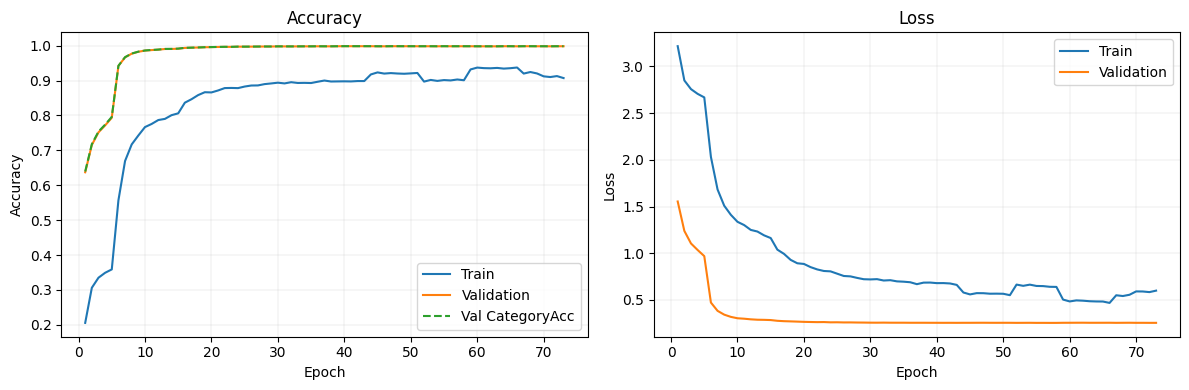

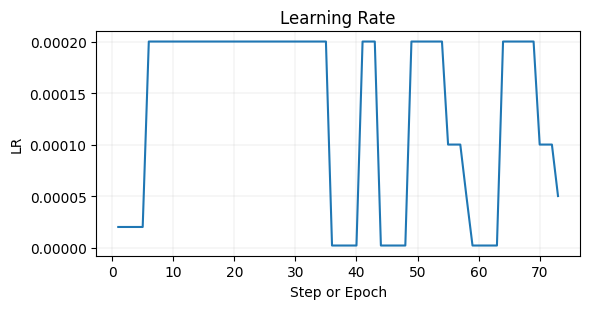

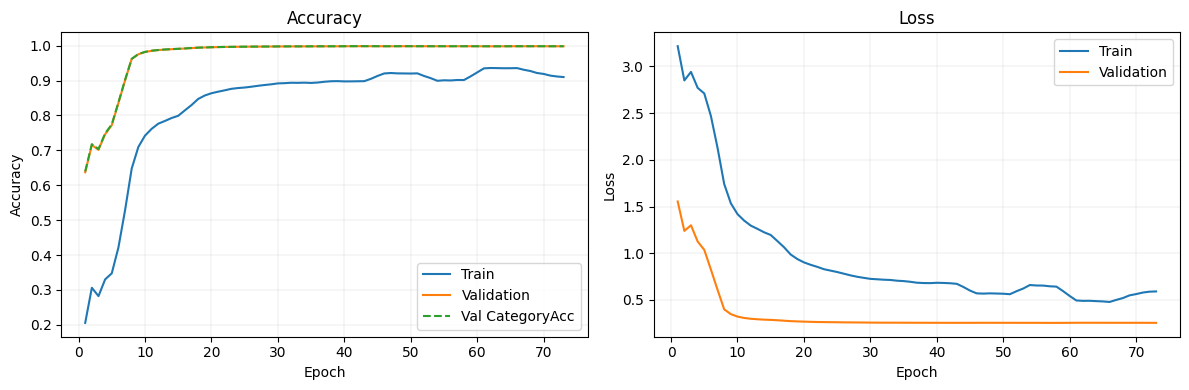

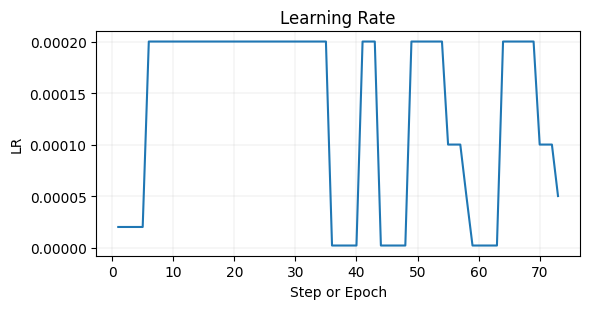

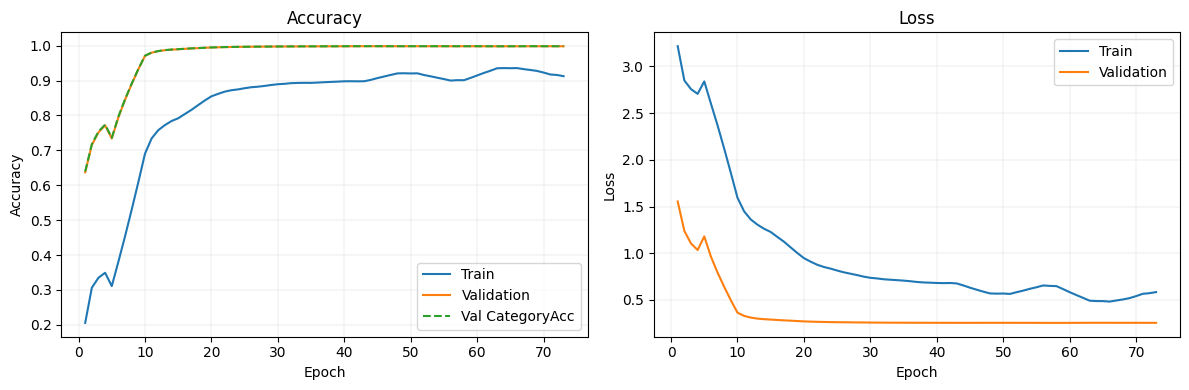

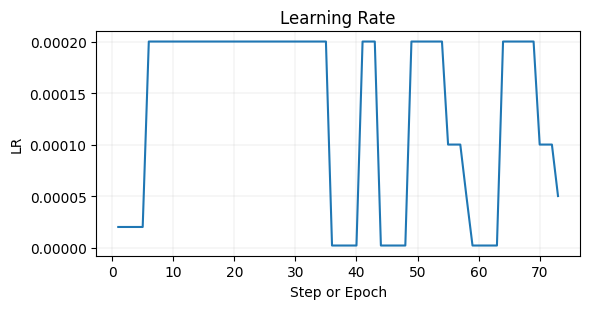

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def _to_list(x):
    if x is None:
        return []
    if hasattr(x, 'detach'):  # torch.Tensor
        x = x.detach().cpu().numpy()
    if hasattr(x, 'tolist'):
        x = x.tolist()
    return list(x)

def _moving_avg(arr, k=1):
    if k <= 1 or len(arr) == 0:
        return arr
    arr = np.asarray(arr, dtype=float)
    k = min(k, len(arr))
    c = np.cumsum(np.insert(arr, 0, 0.0))
    sm = (c[k:] - c[:-k]) / k
    # 對齊長度：前面補原始值
    head = arr[:k-1].tolist()
    return head + sm.tolist()

def plot_training_history(history, smooth_k=1, save_path=None, show_lr=True):
    # 取欄位並轉成 list[float]
    tr_acc = _to_list(history.get('train_acc'))
    va_acc = _to_list(history.get('val_acc'))
    tr_loss = _to_list(history.get('train_loss'))
    va_loss = _to_list(history.get('val_loss'))
    va_cat = _to_list(history.get('val_cat_acc'))  # 可能不存在
    lr_hist = _to_list(history.get('learning_rate'))  # 可能不存在

    # 平滑
    tr_acc_s = _moving_avg(tr_acc, smooth_k)
    va_acc_s = _moving_avg(va_acc, smooth_k)
    tr_loss_s = _moving_avg(tr_loss, smooth_k)
    va_loss_s = _moving_avg(va_loss, smooth_k)
    va_cat_s = _moving_avg(va_cat, smooth_k) if len(va_cat) else []

    # 橫軸
    epochs_acc = range(1, len(tr_acc_s) + 1)
    epochs_loss = range(1, len(tr_loss_s) + 1)

    # 主要圖：acc 與 loss
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(epochs_acc, tr_acc_s, label='Train')
    axes[0].plot(epochs_acc, va_acc_s, label='Validation')
    if len(va_cat_s):
        axes[0].plot(range(1, len(va_cat_s)+1), va_cat_s, linestyle='--', label='Val CategoryAcc')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, linewidth=0.3, alpha=0.5)

    # Loss
    axes[1].plot(epochs_loss, tr_loss_s, label='Train')
    axes[1].plot(epochs_loss, va_loss_s, label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, linewidth=0.3, alpha=0.5)

    plt.tight_layout()

    # 額外圖：Learning Rate（若存在且需要顯示）
    if show_lr and len(lr_hist):
        plt.figure(figsize=(6, 3.2))
        plt.plot(range(1, len(lr_hist)+1), lr_hist)
        plt.title('Learning Rate')
        plt.xlabel('Step or Epoch')
        plt.ylabel('LR')
        plt.grid(True, linewidth=0.3, alpha=0.5)
        plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
plot_training_history(history)                         # 不平滑
plot_training_history(history, smooth_k=3)             # 3 點移動平均
plot_training_history(history, smooth_k=5, show_lr=True, save_path='training_curves.png')


In [8]:
# 檢查數據集
print("檢查訓練數據目錄...")
if os.path.exists('train'):
    print("訓練數據目錄存在")
    print(f"類別數量: {len(os.listdir('train'))}")
    for class_name in sorted(os.listdir('train'))[:5]:
        print(f"類別 '{class_name}' 的圖片數量: {len(os.listdir(os.path.join('train', class_name)))}")
else:
    print("錯誤：訓練數據目錄不存在！")

檢查訓練數據目錄...
訓練數據目錄存在
類別數量: 1
類別 'train' 的圖片數量: 1


In [9]:
# 載入最佳模型進行預測
print("正在載入最佳模型...")
load_path = 'best_model_ema.pth' if os.path.exists('best_model_ema.pth') else 'best_model.pth'
model.load_state_dict(torch.load(load_path))
model.eval()

# 獲取訓練數據集的類別信息
train_root = 'train/train/train'
train_dataset_full = SimpsonsDataset(root_dir=train_root, transform=None, mode='train')
classes = train_dataset_full.classes
print(f"載入的類別數量: {len(classes)}")

            # 創建測試數據集
test_root = 'test-renamed_images/test-renamed_images'  # 修正路徑
test_dataset = SimpsonsDataset(root_dir=test_root, transform=test_transform, mode='test', classes=classes)
print(f"測試集大小: {len(test_dataset)}")

if len(test_dataset) == 0:
    print("錯誤：測試集為空！")
else:
    print("成功載入測試數據")
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 進行預測
    predictions = []
    filenames = []

    with torch.no_grad():
        for inputs, image_names in tqdm(test_loader, desc='進行預測'):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            outputs_flip = model(torch.flip(inputs, dims=[3]))
            outputs = (outputs + outputs_flip) / 2.0
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            filenames.extend(image_names)


    # 創建預測結果
    results_df = pd.DataFrame({
        'id': [int(''.join(filter(str.isdigit, f))) for f in filenames],
        'character': [classes[pred] for pred in predictions]
    })

    # 排序並保存結果
    results_df = results_df.sort_values('id').reset_index(drop=True)
    results_df.to_csv('submission.csv', index=False)
    print(f"\n預測完成！")
    print(f"總預測數量: {len(predictions)}")
    print("前5個預測結果:")
    print(results_df.head())

正在載入最佳模型...
載入的類別數量: 50
測試集大小: 10791
成功載入測試數據


進行預測: 100%|██████████| 675/675 [00:28<00:00, 23.42it/s]


預測完成！
總預測數量: 10791
前5個預測結果:
   id          character
0   1  principal_skinner
1   2  principal_skinner
2   3       ralph_wiggum
3   4        lionel_hutz
4   5      marge_simpson


Collect for ConfMat: 100%|██████████| 1818/1818 [00:38<00:00, 46.76it/s]


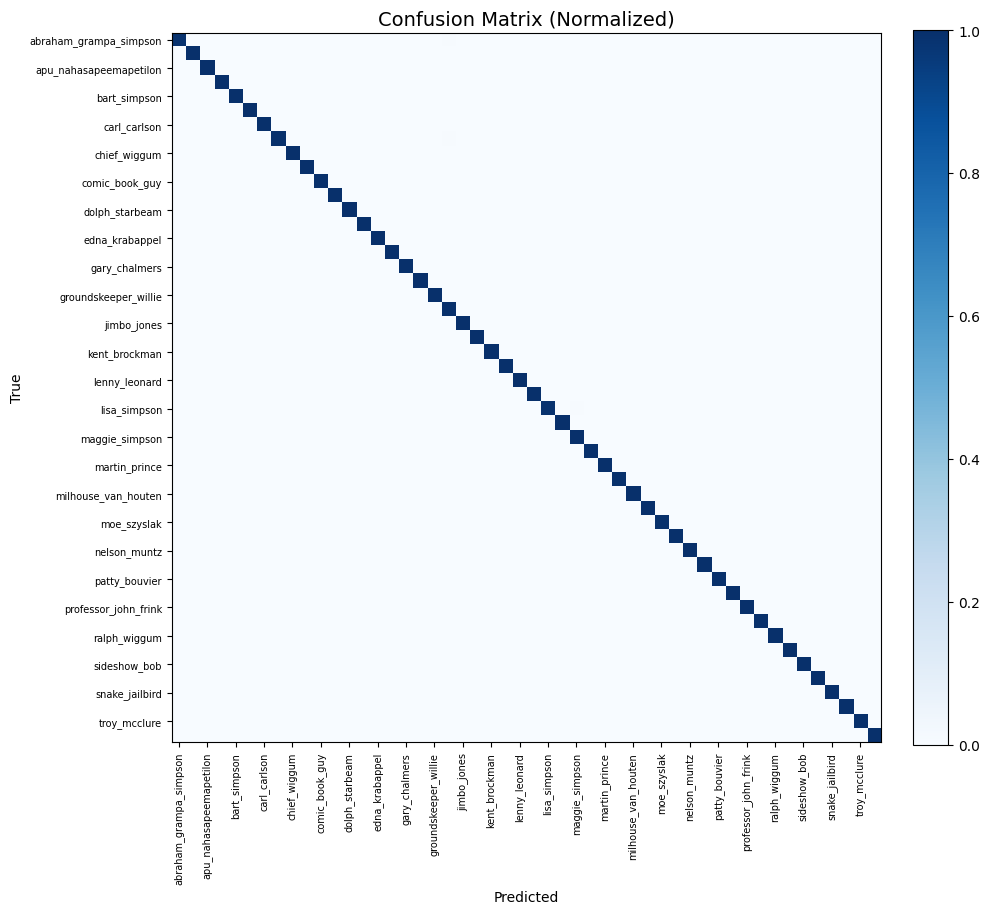

In [10]:
# === Confusion Matrix (50x50) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_confusion_matrix(model, loader, class_names=None, device='cuda', normalize=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Collect for ConfMat'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)) if class_names else None,
                          normalize='true' if normalize else None)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title('Confusion Matrix' + (' (Normalized)' if normalize else ''), fontsize=14)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    if class_names is not None:
        # 列太多，建議抽樣顯示 tick，避免擠在一起
        step = max(1, len(class_names)//25)
        ticks = np.arange(0, len(class_names), step)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([class_names[i] for i in ticks], rotation=90, fontsize=7)
        ax.set_yticklabels([class_names[i] for i in ticks], fontsize=7)

    plt.tight_layout()
    plt.show()
    return cm

# 取得類別名（與你訓練時一致）
try:
    class_names = base_train.dataset.classes if hasattr(base_train, 'dataset') else base_train.classes
except:
    class_names = None

# 計算並畫出（可切換 normalize=True 看比例，或 False 看計數）
cm = evaluate_confusion_matrix(model, val_loader, class_names=class_names, device=DEVICE, normalize=True)


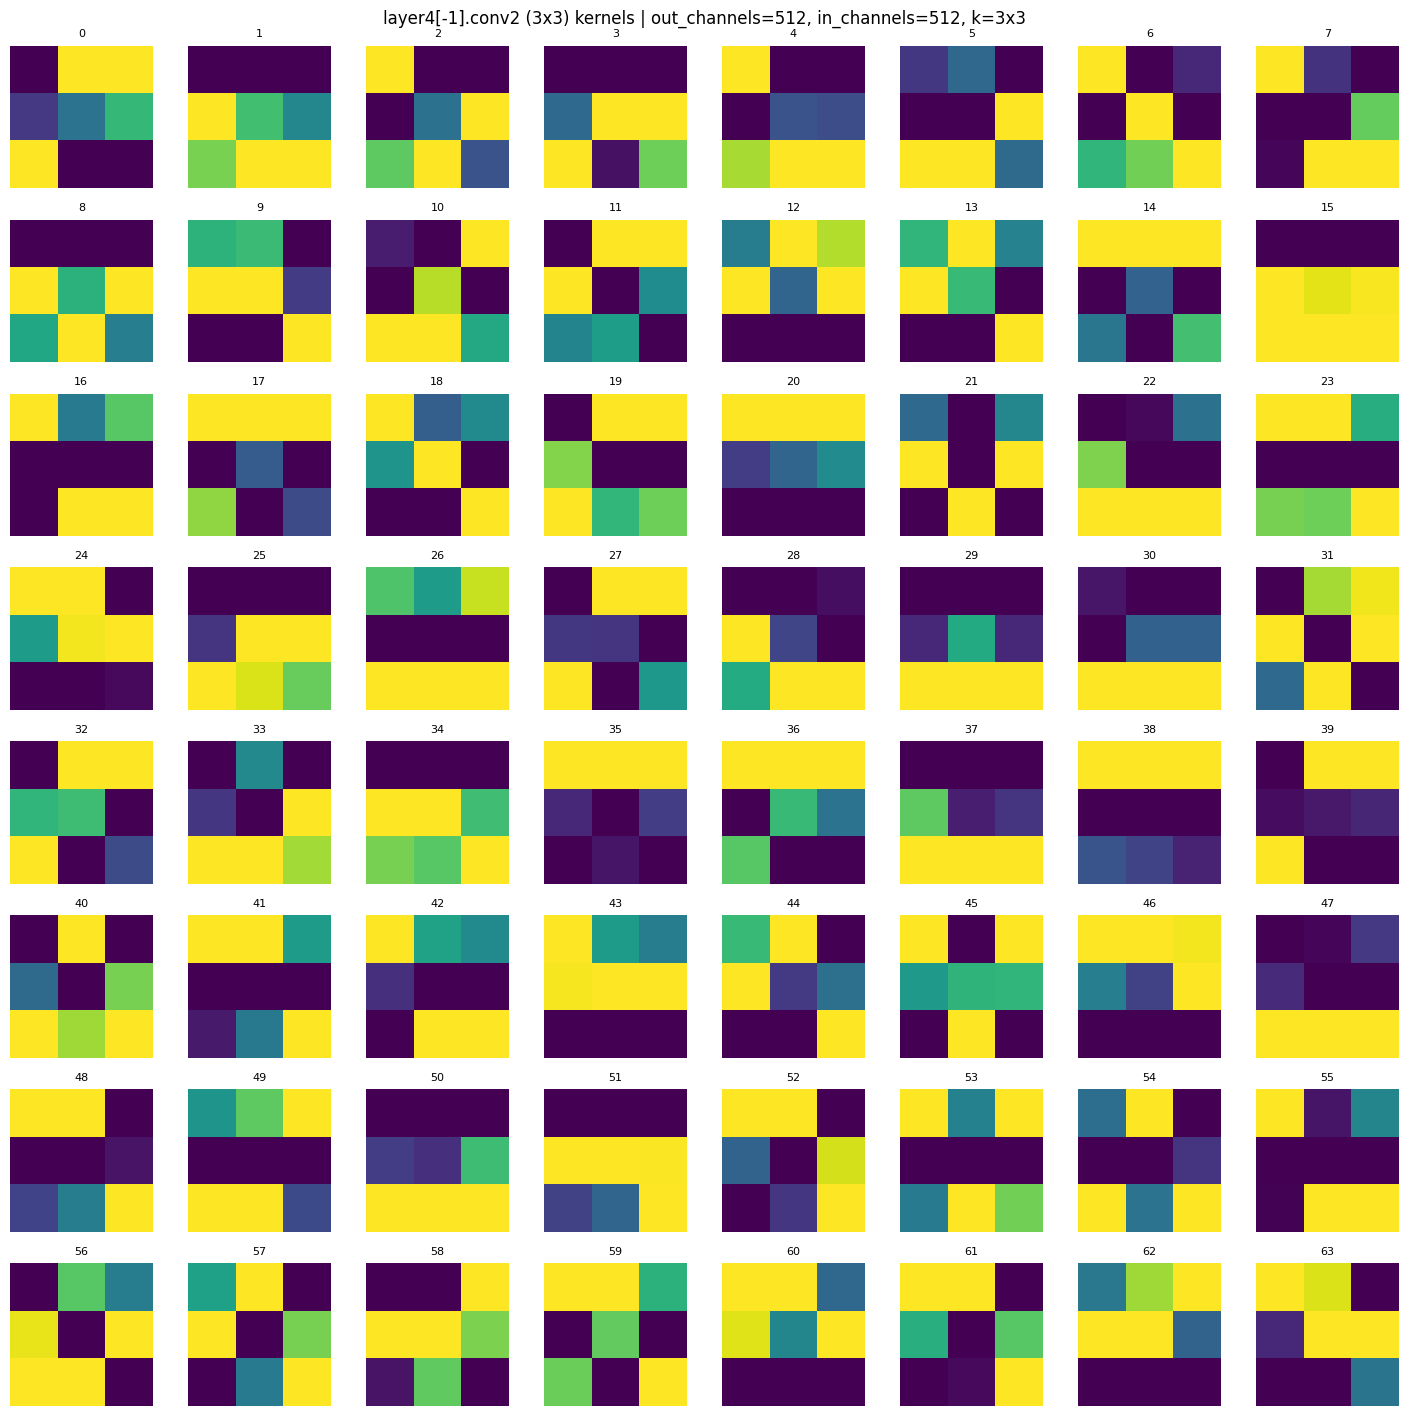

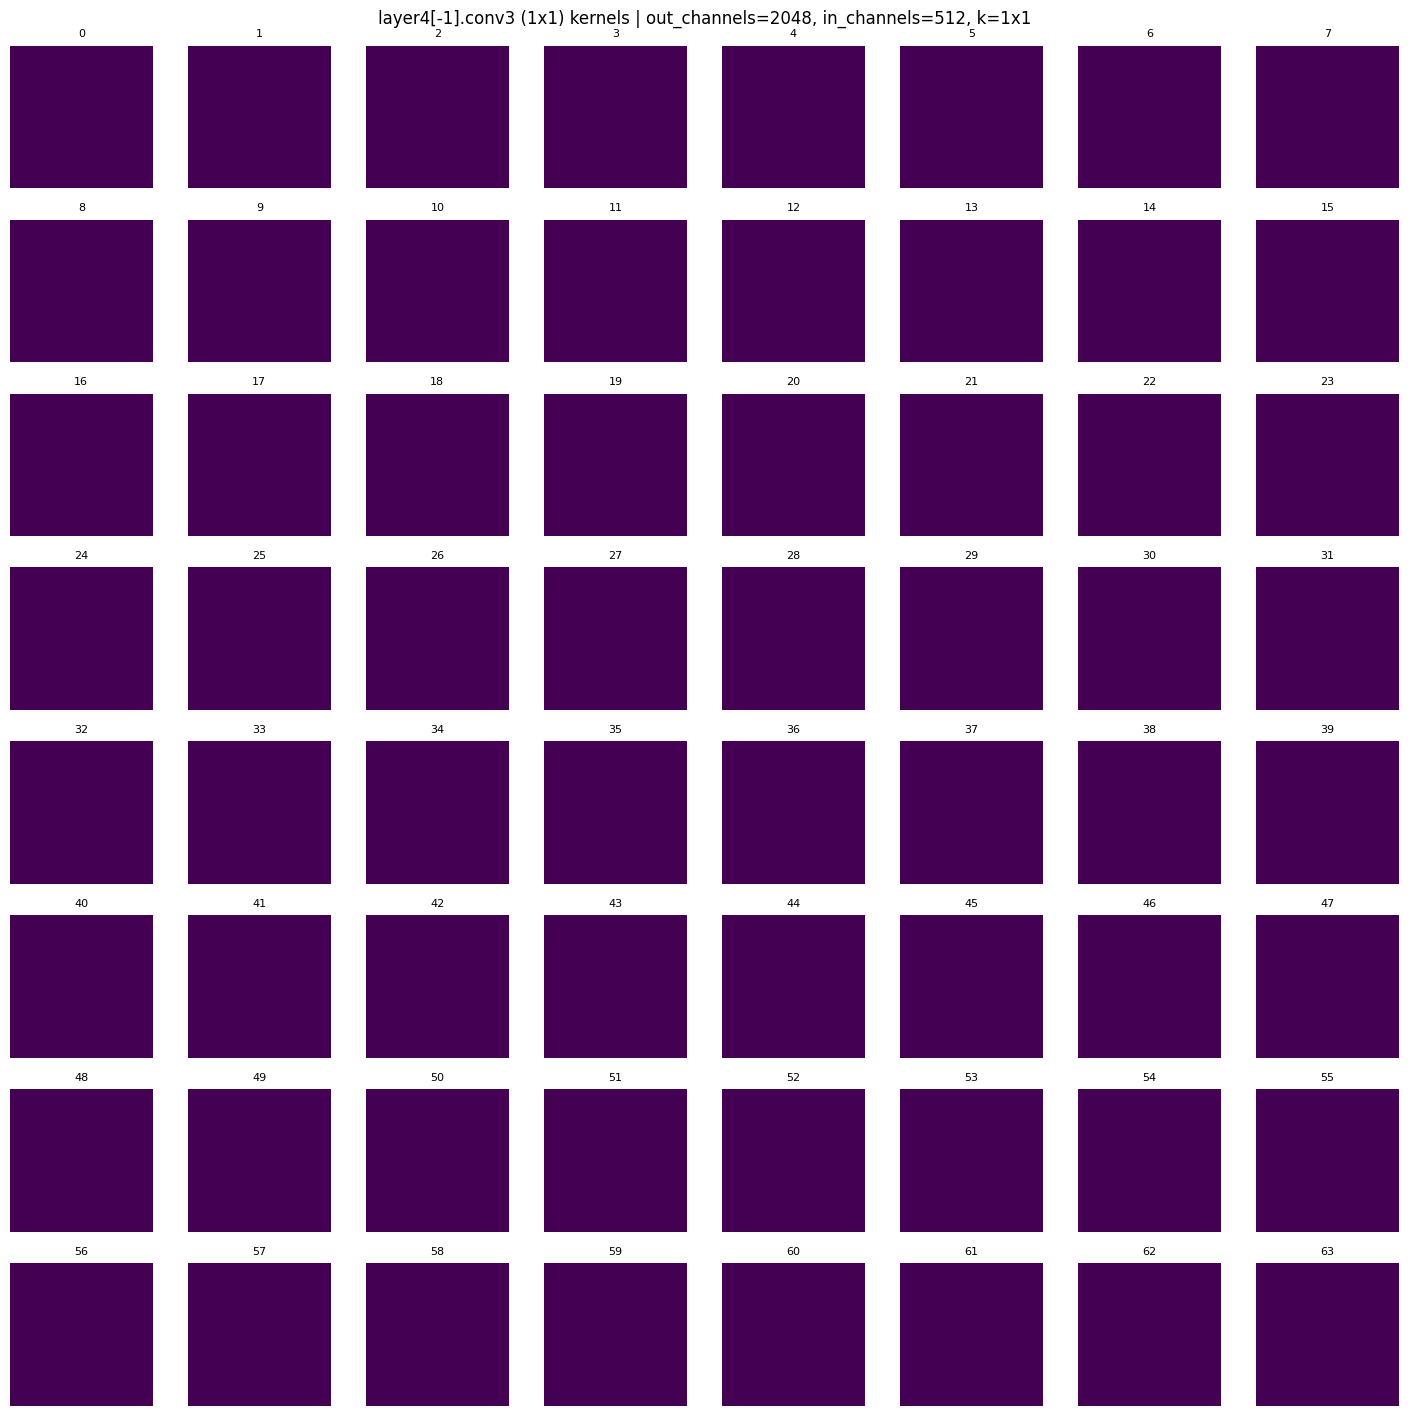

In [12]:
# === Visualize last block's conv filters ===
import math
import matplotlib.pyplot as plt

def show_conv_kernels(conv, max_k=64, title='Conv Kernels (mean over in_channels)'):
    """將每個輸出通道的kernel在 in_channels 維度上取均值，得到一張2D核（對3x3最直觀）。
       max_k: 最多顯示的輸出通道數"""
    W = conv.weight.data.cpu()  # [out_c, in_c, k, k]
    out_c, in_c, kH, kW = W.shape
    n = min(out_c, max_k)

    # 對 in_channels 取均值，得到 [out_c, kH, kW]
    kernels = W.mean(dim=1)
    
    # min-max normalize 每張 kernel，方便顯示
    kernels = (kernels - kernels.min(dim=1, keepdim=True)[0]) / \
            (kernels.max(dim=1, keepdim=True)[0] - kernels.min(dim=1, keepdim=True)[0] + 1e-8)

    cols = 8
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(kernels[i].numpy(), cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'{i}', fontsize=8)
    for i in range(n, len(axes)):
        axes[i].axis('off')
    plt.suptitle(title + f' | out_channels={out_c}, in_channels={in_c}, k={kH}x{kW}', fontsize=12)
    plt.tight_layout()
    plt.show()

# 取最後一個 bottleneck
last_block = model.layer4[-1]

# 推薦：畫 3x3 的 conv2 濾波器（更有空間結構可視化意義）
show_conv_kernels(last_block.conv2, max_k=64, title='layer4[-1].conv2 (3x3) kernels')

# 若你仍想看最後的 1x1 conv（pointwise），也可畫，但空間結構上較不直觀
show_conv_kernels(last_block.conv3, max_k=64, title='layer4[-1].conv3 (1x1) kernels')


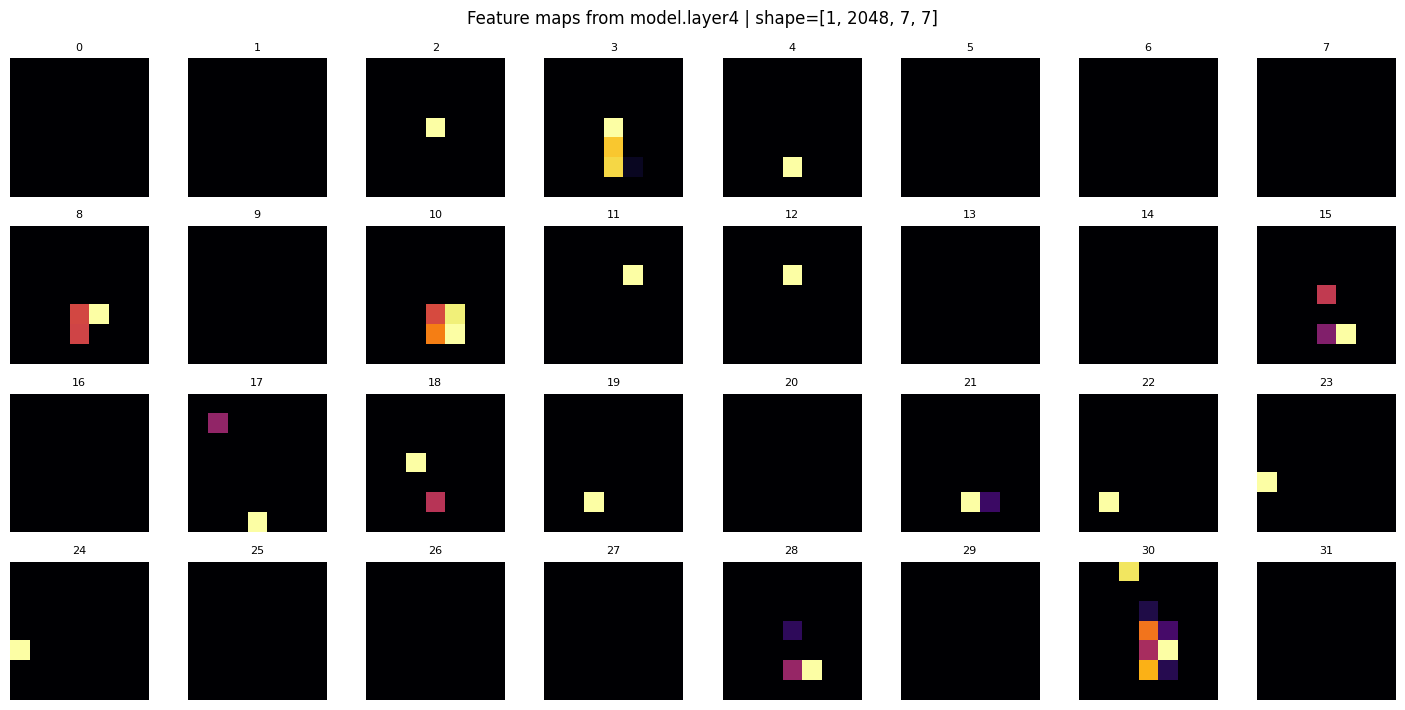

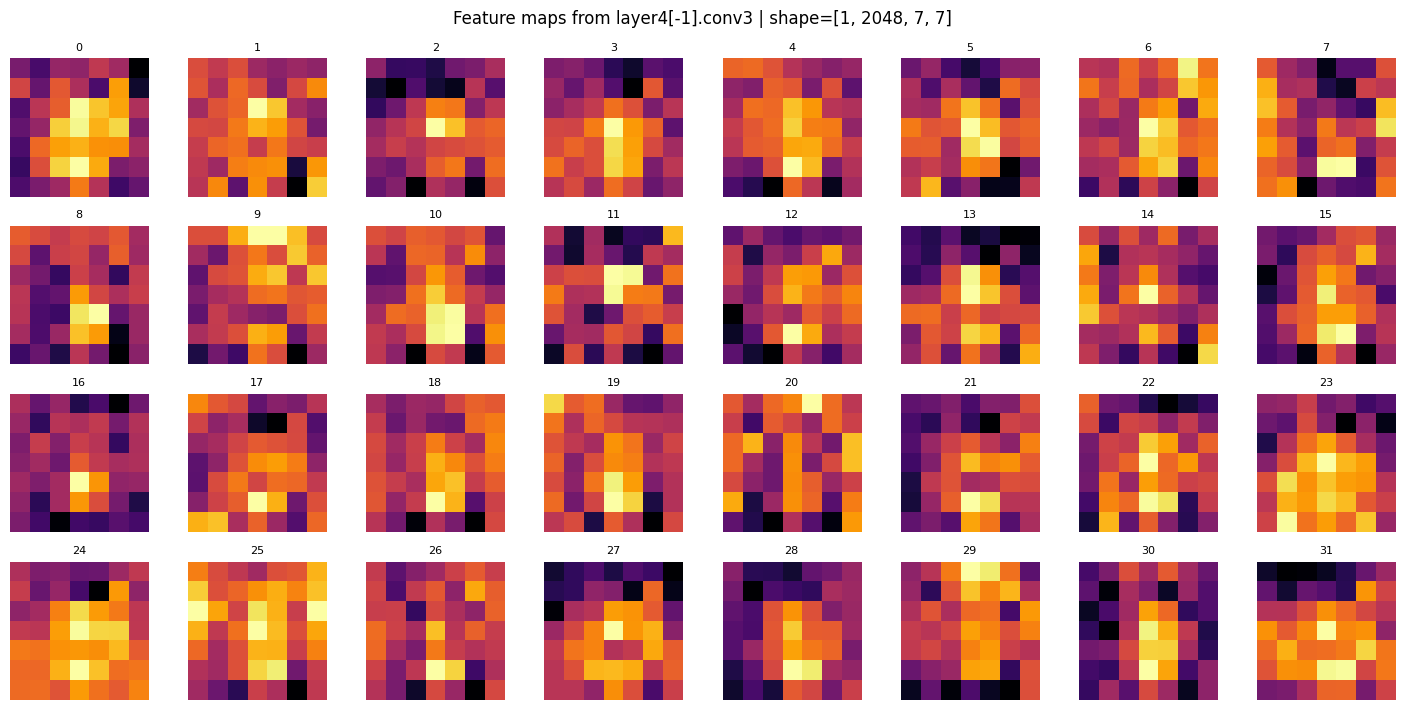

In [13]:
# === Visualize feature maps of the last conv stage ===
import torch
import matplotlib.pyplot as plt
import math

def capture_feature_maps(model, target_module, input_tensor, device='cuda'):
    """對 target_module 註冊 forward hook，回傳特徵圖 (N,C,H,W) 的一張 batch"""
    activations = {}
    def hook_fn(m, inp, out):
        activations['feat'] = out.detach().cpu()
    handle = target_module.register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        _ = model(input_tensor.to(device))
    handle.remove()
    return activations.get('feat')  # Tensor: [N, C, H, W]

def plot_feature_maps(feat, max_channels=32, title='Feature Maps'):
    """feat: Tensor [N, C, H, W]，只畫第一張 (N=1) 的前 max_channels 個通道"""
    if feat is None:
        print("No features captured.")
        return
    fm = feat[0]  # [C, H, W]
    C, H, W = fm.shape
    n = min(C, max_channels)

    # 每個通道 min-max normalize 後顯示
    fm = fm.clone()
    for c in range(C):
        m, M = fm[c].min(), fm[c].max()
        fm[c] = (fm[c] - m) / (M - m + 1e-8)

    cols = 8
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(fm[i].numpy(), cmap='inferno')
        axes[i].axis('off')
        axes[i].set_title(f'{i}', fontsize=8)
    for i in range(n, len(axes)):
        axes[i].axis('off')
    plt.suptitle(title + f' | shape={list(feat.shape)}', fontsize=12)
    plt.tight_layout()
    plt.show()

# 從驗證集中抓一張影像來看特徵圖
model.eval()
sample_img = None
for x, y in val_loader:
    sample_img = x[:1]  # 取 batch 中的第一張 [1,3,224,224]
    break

# A. 抓 layer4 的輸出（常見）
feat_layer4 = capture_feature_maps(model, model.layer4, sample_img, device=DEVICE)
plot_feature_maps(feat_layer4, max_channels=32, title='Feature maps from model.layer4')

# B. 抓最後 bottleneck 的 conv3 輸出（最靠近 GAP/FC 前）
feat_last_conv = capture_feature_maps(model, model.layer4[-1].conv3, sample_img, device=DEVICE)
plot_feature_maps(feat_last_conv, max_channels=32, title='Feature maps from layer4[-1].conv3')
